# Maximum likelihood retrieval techniques in the presence of Poisson noise

The purpose of this notebook is to play with iterative retrieval algorithms that can be used to extract IFS data, but with the hope that the formalisms that we introduce can be used in other situations as well.

One of the tricky parts is to characterize how much better these algorithms are compared to regular chi-squared extraction/deconvolution methods. One approach is to compare their SNRs. In order to determine the uncertainty (used to compute SNR), we are just going to repeat the flux extraction a large number of times and compute the standard deviation of the estimates.

One other tricky part is to know whether the extraction is biased, and quantify how much. We are going to try to defer this to a later date.

In [1]:
import numpy as np
import glob
%pylab inline --no-import-all
plt.rc('font', family='serif', serif='Times',size=20)
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=20)
plt.rc('xtick.major', size=10)
plt.rc('ytick.major', size=10)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('figure',titlesize=20)
plt.rc('image',origin='lower',interpolation='nearest')

import sys
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
from crispy.tools.initLogger import getLogger
log = getLogger('crispy')

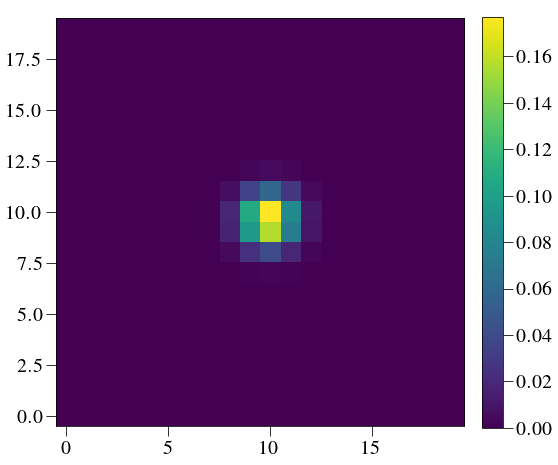

In [3]:
from scipy.special import erf
size = 20
# add some static offset to reflect arbitrary sampling
_x = np.arange(size)-size//2+0.1
_y = np.arange(size)-size//2+0.4
_x, _y = np.meshgrid(_x, _y)
sigma = 2./2.35
psflet = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

psflet /= np.sum(psflet)
fsize=8
plt.figure(figsize=(fsize,fsize))
plt.imshow(psflet)
plt.colorbar(fraction=0.046, pad=0.04)


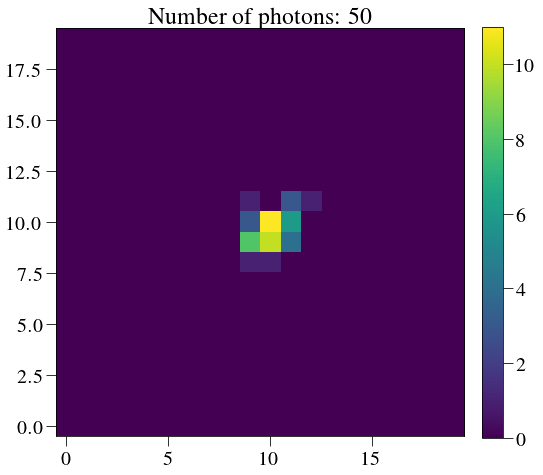

In [4]:
Nphot = 50
img = np.random.poisson(psflet*50)
plt.figure(figsize=(fsize,fsize))
plt.imshow(img)
plt.title('Number of photons: {:}'.format(Nphot))
plt.colorbar(fraction=0.046, pad=0.04)


## Naive matched filter attempt assuming perfect centroid

In [5]:
mf = psflet.copy()
mf /= np.sum(mf**2)

In [6]:
log.info(np.sum(img*mf))

crispy - INFO - 56.8535298426


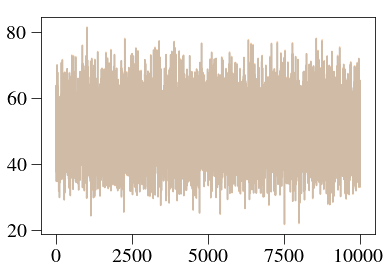

In [117]:
niter = 10000
tsum = np.zeros(niter)
matched_filtered = np.zeros(niter)
linregress = np.zeros(niter)
wls_model = np.zeros(niter)
for i in range(niter):
    img = np.random.poisson(psflet*Nphot)
    matched_filtered[i] = np.sum(img*mf)
    tsum[i] = np.sum(img)
    linregress[i]= scipy.stats.linregress(np.reshape(psflet,-1), np.reshape(img,-1))[0]
    wls_tmp = sm.WLS(np.reshape(img,-1).T, np.reshape(psflet,-1).T, weights=1./np.reshape(psflet+1e-10,-1).T)
    results = wls_tmp.fit()
    wls_model[i]=results.params[0]
    
plt.plot(matched_filtered,alpha=0.3)
plt.plot(linregress,alpha=0.3)

In [118]:
log.info("Sum | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(tsum),np.std(tsum),np.sqrt(np.mean(tsum)),np.mean(tsum)/np.std(tsum)))
log.info("Matched filter | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(matched_filtered),np.std(matched_filtered),np.sqrt(np.mean(matched_filtered)),np.mean(matched_filtered)/np.std(matched_filtered)))
log.info("Linear regression | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(linregress),np.std(linregress),np.sqrt(np.mean(linregress)),np.mean(linregress)/np.std(linregress)))
log.info("Poisson-weighted lstsq | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(wls_model),np.std(wls_model),np.sqrt(np.mean(wls_model)),np.mean(wls_model)/np.std(wls_model)))

crispy - INFO - Sum | Mean: 50.127, Std: 7.18, sqrt(Mean): 7.08, SNR: 6.98
crispy - INFO - Matched filter | Mean: 50.104, Std: 8.24, sqrt(Mean): 7.08, SNR: 6.08
crispy - INFO - Linear regression | Mean: 50.103, Std: 8.29, sqrt(Mean): 7.08, SNR: 6.04
crispy - INFO - Poisson-weighted lstsq | Mean: 50.127, Std: 7.18, sqrt(Mean): 7.08, SNR: 6.98


## Now with two sources

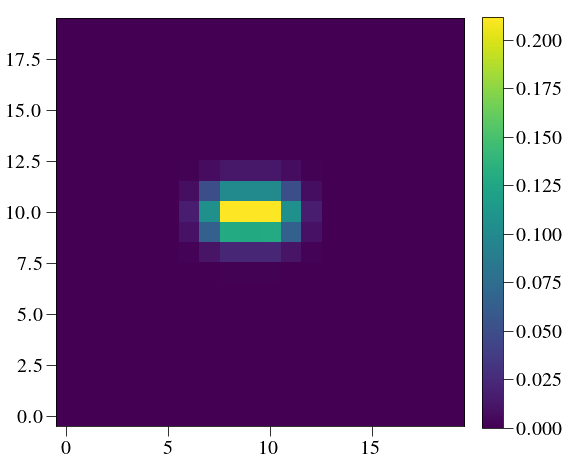

In [7]:
_x = np.arange(size)-size//2+2
_y = np.arange(size)-size//2+0.1
_x, _y = np.meshgrid(_x, _y)
sigma = 2./2.35
psflet1 = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

psflet1 /= np.sum(psflet1)

_x = np.arange(size)-size//2
_y = np.arange(size)-size//2+0.1
_x, _y = np.meshgrid(_x, _y)
sigma = 2./2.35
psflet2 = (erf((_x + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_x - 0.5) / (np.sqrt(2) * sigma))) * \
    (erf((_y + 0.5) / (np.sqrt(2) * sigma)) - \
    erf((_y - 0.5) / (np.sqrt(2) * sigma)))

psflet2 /= np.sum(psflet2)



plt.figure(figsize=(fsize,fsize))
plt.imshow(psflet1+psflet2)
plt.colorbar(fraction=0.046, pad=0.04)


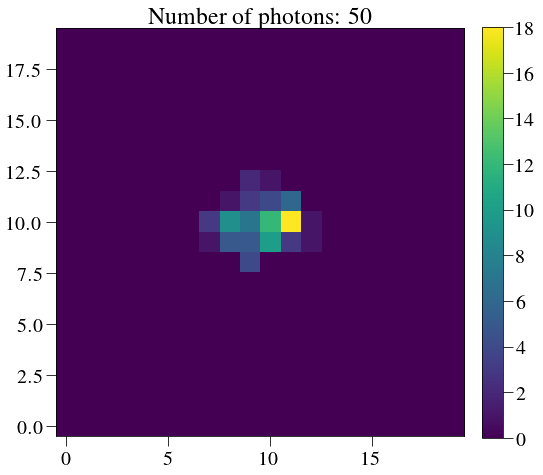

In [12]:
Nphot1 = 20
Nphot2 = 80
img = np.random.poisson(psflet1*Nphot1+psflet2*Nphot2)
plt.figure(figsize=(fsize,fsize))
plt.imshow(img)
plt.title('Number of photons: {:}'.format(Nphot))
plt.colorbar(fraction=0.046, pad=0.04)


In [13]:
psflets = np.zeros((2,psflet1.shape[0],psflet1.shape[1]))
psflets[0] = psflet1.copy()
psflets[1] = psflet2.copy()
psflets_flat = np.reshape(psflets, (psflets.shape[0], -1))

In [14]:
subim_flat = np.reshape(img, -1)
coef = np.linalg.lstsq(psflets_flat.T, subim_flat)[0]

In [15]:
print coef

[ 24.08858657  72.41525746]


## Richardson-Lucy method in the presence of Poisson noise

Method is:
1. Use least squares as first guess
2. Update next guess according to Snyder et al 1993 Eq. 4
3. Stop at some point (e.g. when change from step to step is under a threshold

In [16]:
def RL(img,psflets,eps=1e-10):
    #1.
    psflets_flat = np.reshape(psflets.copy(), (psflets.shape[0], -1))
    img_flat = np.reshape(img, -1)
    # guess has dimensions of psflets.shape[0]
    guess = np.linalg.lstsq(psflets_flat.T, img_flat)[0]
    #guess = [ 1, 1]
    res = []
    res.append(guess)
    loglike = []
    ll = -np.sum(np.dot(guess,psflets_flat)) + np.sum(np.log(np.dot(guess,psflets_flat)+1e-10)*img_flat)
    prevll = -np.inf
    loglike.append(ll)
    val = guess.copy()
    count = 0
    while ll-prevll > eps:
        prev = val.copy()
        prevll = ll.copy()
        ll = -np.sum(np.dot(prev,psflets_flat)) + np.sum(np.log(np.dot(prev,psflets_flat)+1e-10)*img_flat)
        loglike.append(ll)
        #2. update
        val = prev*np.sum(psflets_flat*img_flat/(np.dot(prev,psflets_flat)+1e-10),axis=1)
        res.append(val)
        count += 1
    return val,np.array(res),np.array(loglike),count

/Users/mrizzo/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log


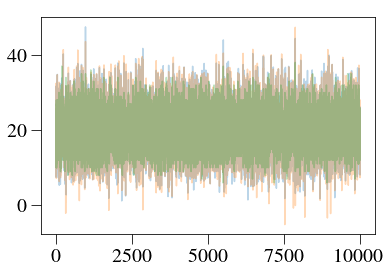

In [17]:
niter = 10000
lstsq = np.zeros((2,niter))
lucy = np.zeros((2,niter))
true = np.zeros((2,niter))
for i in range(niter):
#     min_num_int = max(np.amax(psflet1)*Nphot1/0.1,np.amax(psflet2)*Nphot2/0.1)
#     img1 = np.zeros_like(psflet1)
#     img2 = np.zeros_like(psflet2)
#     for j in range(int(min_num_int)):
#         val = np.random.poisson(psflet1*Nphot1/min_num_int)
#         img1 += val
#         val = np.random.poisson(psflet2*Nphot2/min_num_int)
#         img2 += val
    img1 = np.random.poisson(psflet1*Nphot1)
    img2 = np.random.poisson(psflet2*Nphot2)
    img = img1+img2
    subim_flat = np.reshape(img/(np.sqrt(psflet1+psflet2)+1e-10), -1)
    sumpsflets = np.reshape(psflet1+psflet2,-1)
    lstsq[:,i] = np.linalg.lstsq(psflets_flat.T/(np.sqrt(sumpsflets[:,np.newaxis]+1e-10)), subim_flat)[0]
    lucy[:,i] = RL(img,psflets_flat)[0]
    true[0,i] = np.sum(img1)
    true[1,i] = np.sum(img2)

    
plt.plot(lstsq[0],alpha=0.3)
plt.plot(lucy[0],alpha=0.3)
plt.plot(true[0],alpha=0.3)


In [28]:
log.info("True 1  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(true[0]),np.std(true[0]),np.sqrt(np.mean(true[0])),np.mean(true[0])/np.std(true[0])))
log.info("True 2  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(true[1]),np.std(true[1]),np.sqrt(np.mean(true[1])),np.mean(true[1])/np.std(true[1])))
log.info("Lstsq 1  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lstsq[0]),np.std(lstsq[0]),np.sqrt(np.mean(lstsq[0])),np.mean(lstsq[0])/np.std(lstsq[0])))
log.info("Lstsq 2  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lstsq[1]),np.std(lstsq[1]),np.sqrt(np.mean(lstsq[1])),np.mean(lstsq[1])/np.std(lstsq[1])))
log.info("lucy 1  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lucy[0]),np.std(lucy[0]),np.sqrt(np.mean(lucy[0])),np.mean(lucy[0])/np.std(lucy[0])))
log.info("lucy 2  | Mean: {:.3F}, Std: {:.3}, sqrt(Mean): {:.3}, SNR: {:.3}".format(np.mean(lucy[1]),np.std(lucy[1]),np.sqrt(np.mean(lucy[1])),np.mean(lucy[1])/np.std(lucy[1])))
log.info("mse lstsq  | {:.3F}".format(np.sqrt(np.mean(((arr-lstsq)/true)**2,axis=1)[0])))
log.info("mse lstsq  | {:.3F}".format(np.sqrt(np.mean(((arr-lstsq)/true)**2,axis=1)[1])))
log.info("mse lucy  | {:.3F}".format(np.sqrt(np.mean(((arr-lucy)/true)**2,axis=1)[0])))
log.info("mse lucy  | {:.3F}".format(np.sqrt(np.mean(((arr-lucy)/true)**2,axis=1)[1])))
arr = np.zeros((2,niter))
arr[0,:] = Nphot1
arr[1,:] = Nphot2
log.info("mse true  | {:.3F}".format(np.sqrt(np.mean(((true-arr)/true)**2,axis=1)[0])))
log.info("mse true  | {:.3F}".format(np.sqrt(np.mean(((true-arr)/true)**2,axis=1)[1])))



crispy - INFO - True 1  | Mean: 19.940, Std: 4.43, sqrt(Mean): 4.47, SNR: 4.5
crispy - INFO - True 2  | Mean: 79.895, Std: 8.94, sqrt(Mean): 8.94, SNR: 8.94
crispy - INFO - Lstsq 1  | Mean: 19.910, Std: 5.95, sqrt(Mean): 4.46, SNR: 3.35
crispy - INFO - Lstsq 2  | Mean: 79.924, Std: 9.84, sqrt(Mean): 8.94, SNR: 8.12
crispy - INFO - lucy 1  | Mean: 19.922, Std: 5.99, sqrt(Mean): 4.46, SNR: 3.32
crispy - INFO - lucy 2  | Mean: 79.914, Std: 9.85, sqrt(Mean): 8.94, SNR: 8.11
crispy - INFO - mse lstsq  | 0.344
crispy - INFO - mse lstsq  | 0.129
crispy - INFO - mse lucy  | 0.349
crispy - INFO - mse lucy  | 0.129
crispy - INFO - mse true  | 0.271
crispy - INFO - mse true  | 0.118


## Now using a full microspectrum of N PSFs

crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Writing data to ..//SimResults/BB_red_lstsq_resid.fits
crispy - INFO - Writing data to ..//SimResults/BB_red_lstsq_model.fits
crispy - INFO - Elapsed time: 4.067425s
crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits
crispy - INFO - Reduced cube will have 26 wavelength bins
crispy - INFO - Elapsed time: 1.530765s
crispy - INFO - Reduced cube will have 11 wavelength bins
crispy - INFO - Reduced cube will have 26 wavelength bins
0.20249073478


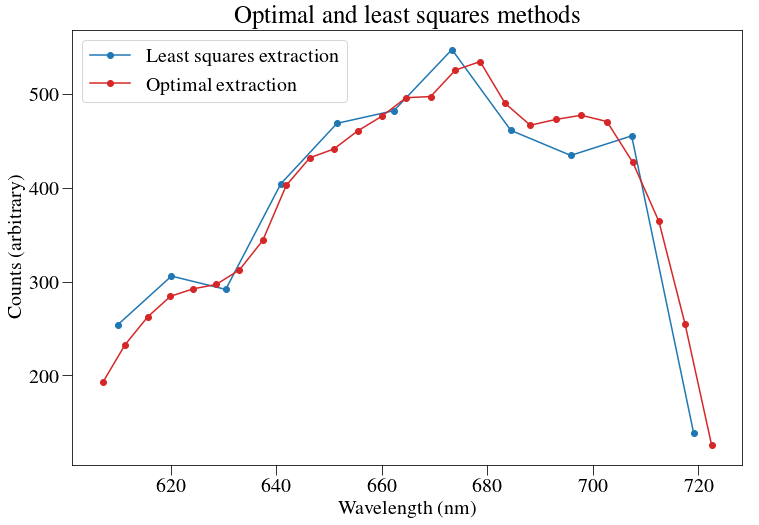

In [3]:
from crispy.tools.image import Image
os.chdir('/Users/mrizzo/IFS/crispy/crispy/PISCES/')
from params import Params
par = Params()
par.hdr

from crispy.unitTests import testFitCutout
from crispy.IFS import reduceIFSMap
from crispy.tools.reduction import calculateWaveList
spectral_cube = reduceIFSMap(par,par.codeRoot+'/Inputs/BB.fits',method='lstsq',fitbkgnd=False,smoothbad=False)
spectrum = spectral_cube.data[:,54,54]
optspect = reduceIFSMap(par,par.codeRoot+'/Inputs/BB.fits',method='optext')
plt.figure(figsize=(12,8))
lam_midpts,lam_endpts = calculateWaveList(par)
plt.plot(lam_midpts,spectrum,'o-',color='#1f77b4')
lam_midpts,lam_endpts = calculateWaveList(par,method="optext")
spect = optspect.data[:,54,54]
ratio = np.mean(spectrum)/np.mean(spect)
print ratio
plt.plot(lam_midpts,spect*ratio,'o-',color='#d62728')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Wavelength (nm)',fontsize=20)
plt.ylabel('Counts (arbitrary)',fontsize=20)
plt.title('Optimal and least squares methods',fontsize=25)
plt.legend(["Least squares extraction","Optimal extraction"],fontsize=20)

crispy - INFO - Read data from HDU 1 of ..//Inputs/BB.fits


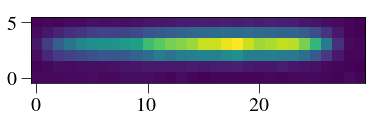

In [4]:
from crispy.tools.reduction import RL,get_cutout,fit_cutout
from crispy.tools.image import Image
from astropy.io import fits

polychromeR = fits.open(par.wavecalDir + 'polychromeR%d.fits' % (par.R))
psflets = polychromeR[0].data

polychromekey = fits.open(par.wavecalDir + 'polychromekeyR%d.fits' % (par.R))
xindx = polychromekey[1].data
yindx = polychromekey[2].data
good = polychromekey[3].data
ifsimage = Image(par.codeRoot+'/Inputs/BB.fits')
i = 54
j = 54
dy=3
subim, psflet_subarr, [y0, y1, x0, x1] = get_cutout(ifsimage,xindx[:,i,j],yindx[:,i,j],psflets,dy)
plt.imshow(subim)

In [27]:
subim_flat = np.reshape(subim, -1)
psflets_flat = np.reshape(psflet_subarr, (psflet_subarr.shape[0], -1))
for i in range(psflets_flat.shape[0]):
    psflets_flat[i] /= np.sum(psflets_flat[i])
leastsq = np.linalg.lstsq(psflets_flat.T, subim_flat)[0]
lucy = RL(subim_flat,psflets_flat)[0]
print np.sum(psflets_flat[0])

1.0


crispy - INFO - Reduced cube will have 11 wavelength bins
[ 609.9964569   620.11350281  630.39834414  640.85376386  651.48259108
  662.28770183  673.27201986  684.43851739  695.79021595  707.33018716
  719.06155361]
crispy - INFO - Reduced cube will have 26 wavelength bins
[ 607.10887147  611.34869295  615.61812376  619.91737068  624.24664194
  628.6061472   632.99609763  637.41670582  641.86818589  646.35075344
  650.86462556  655.41002088  659.98715953  664.59626322  669.23755516
  673.91126015  678.61760456  683.35681631  688.12912494  692.9347616
  697.77395902  702.64695159  707.55397533  712.49526788  717.47106857
  722.48161839]
2.18546151924


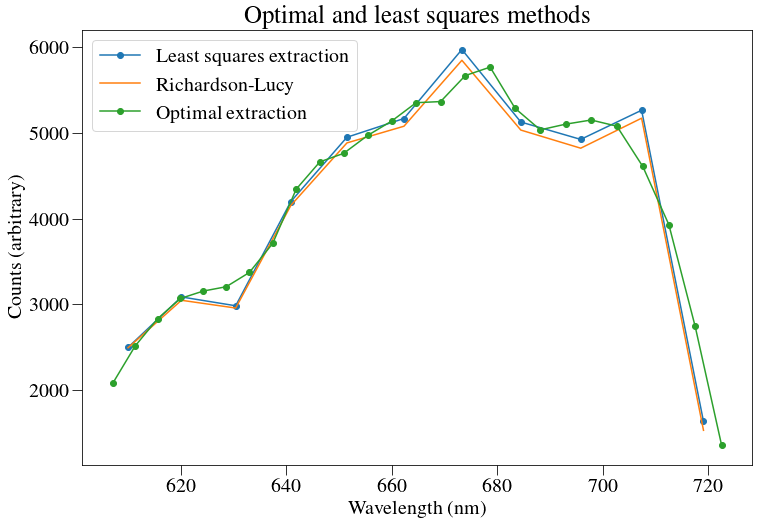

In [28]:
plt.figure(figsize=(12,8))
lam_midpts,lam_endpts = calculateWaveList(par)
print lam_midpts
plt.plot(lam_midpts,leastsq,'o-',label='Least squares extraction')
plt.plot(lam_midpts,lucy,label='Richardson-Lucy')
lam_midpts,lam_endpts = calculateWaveList(par,method="optext")
print lam_midpts
spect = optspect.data[:,54,54]
ratio = np.mean(leastsq)/np.mean(spect)
print ratio
plt.plot(lam_midpts,spect*ratio,'o-',label='Optimal extraction')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Wavelength (nm)',fontsize=20)
plt.ylabel('Counts (arbitrary)',fontsize=20)
plt.title('Optimal and least squares methods',fontsize=25)
plt.legend(fontsize=20)


## Take the least squares solution, and recreate a Poisson-distributed micro-spectrum

45800.6


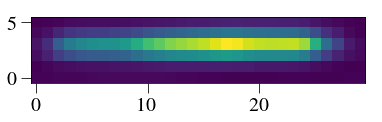

In [29]:
newvect = np.zeros_like(subim)
for i in range(psflets_flat.shape[0]):
    newvect += psflet_subarr[i]*leastsq[i]
plt.imshow(newvect)
print(np.sum(newvect))

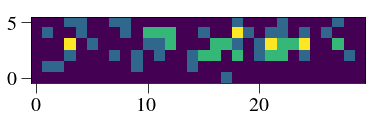

In [30]:
Nphot = 100
newvect *= Nphot/np.sum(newvect)

new = np.random.poisson(newvect)

plt.imshow(new)

In [25]:
new_flat = np.reshape(new, -1)
leastsq = np.linalg.lstsq(psflets_flat.T, new_flat)[0]
lucy = RL(new_flat,psflets_flat)[0]


crispy - INFO - Reduced cube will have 11 wavelength bins
[ 609.9964569   620.11350281  630.39834414  640.85376386  651.48259108
  662.28770183  673.27201986  684.43851739  695.79021595  707.33018716
  719.06155361]


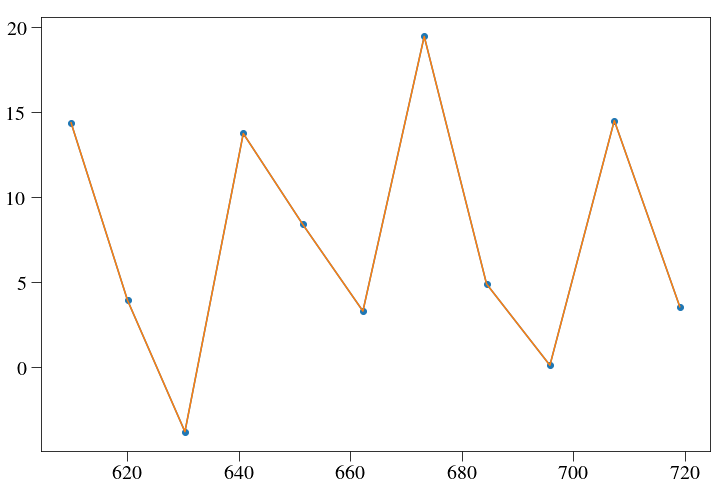

In [26]:
plt.figure(figsize=(12,8))
lam_midpts,lam_endpts = calculateWaveList(par)
print lam_midpts
plt.plot(lam_midpts,leastsq,'o-',label='Least squares extraction')
plt.plot(lam_midpts,lucy,label='Richardson-Lucy')
